In [11]:
import numpy as np
from matplotlib import pyplot as plt
from classes.policy_network import PolicyNetwork
from classes.diffusion_model import DiffusionModel
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from methods import sample_batch
from methods import reward_function
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from time import time

In [12]:
DEVICE = 'mps'

In [13]:
model_name = "01"
path_to_weights = (
    "/Users/hazimiasad/Documents/Work/megan/data/collection/Study1/sub-"
    + model_name
    + "/pattern/dc_weights.csv"
)
weights = torch.from_numpy(pd.read_csv(path_to_weights, header=None).values.T).to(
    DEVICE, dtype=torch.float32
)
state_size = len(weights)

In [14]:
all_models_path = '/Users/hazimiasad/Documents/Work/megan/code/playground/RL-Diffusion/results/models/sub-'+model_name
save_path = '/Users/hazimiasad/Documents/Work/megan/code/playground/RL-Diffusion/results/Imgs/sub-'+model_name+'/'

In [15]:
def list_files_in_directory(directory):
    """
    List all files in the given directory, including their full paths.

    :param directory: Path to the directory
    :return: List of full file paths
    """
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list

In [16]:
all_models = list_files_in_directory(all_models_path)

In [17]:
def init_model(device):
    policy_net = PolicyNetwork(state_size, state_size, device=device).to(device)
    model = DiffusionModel(policy_net, device=device)
    return model


In [18]:
def load_model(model, path):
    # checkpoint_path = "/Users/hazimiasad/Documents/Work/megan/code/playground/RL-Diffusion/results/models/1736749094.248426.pth"
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

In [30]:
all_rewards = np.zeros((len(all_models[:100]), 100, 40))
for i, model_path in enumerate(all_models):
    model = init_model(DEVICE)
    model = load_model(model, model_path)
    step_scores = calc_step_scores(model)
    all_rewards[i, :, :] = step_scores

KeyboardInterrupt: 

In [20]:
def calc_step_scores(model):
    xs = np.zeros((100, 40))
    for i in range(100):
        x = torch.from_numpy(sample_batch(state_size)).float().to(DEVICE)
        states = []
        for t in range(40, 0, -1):
            states.append(x)
            action, _, _, _ = model.select_action(x, t)
            x = x + action
            
        rewards = [reward_function(x, weights).item() for x in states]
        xs[i, :] = np.array(rewards)
    return xs

In [21]:
def plot_CI(xs, label='Mean'):
    mean = np.mean(xs, axis=0)
    sem = np.std(xs, axis=0) / np.sqrt(xs.shape[0])  # SEM = std / sqrt(n)

    # Compute confidence intervals (e.g., 95% CI)
    ci_upper = mean + 1.96 * sem
    ci_lower = mean - 1.96 * sem

    # Plot the mean
    plt.plot(mean, label=label)

    # Fill the confidence interval
    plt.fill_between(range(mean.shape[0]), ci_lower, ci_upper,  alpha=0.2)#, label='95% CI'

    # Add labels and legend
    plt.xlabel('Denoising step')
    plt.ylabel('Score')
    # plt.legend()
    # plt.show()

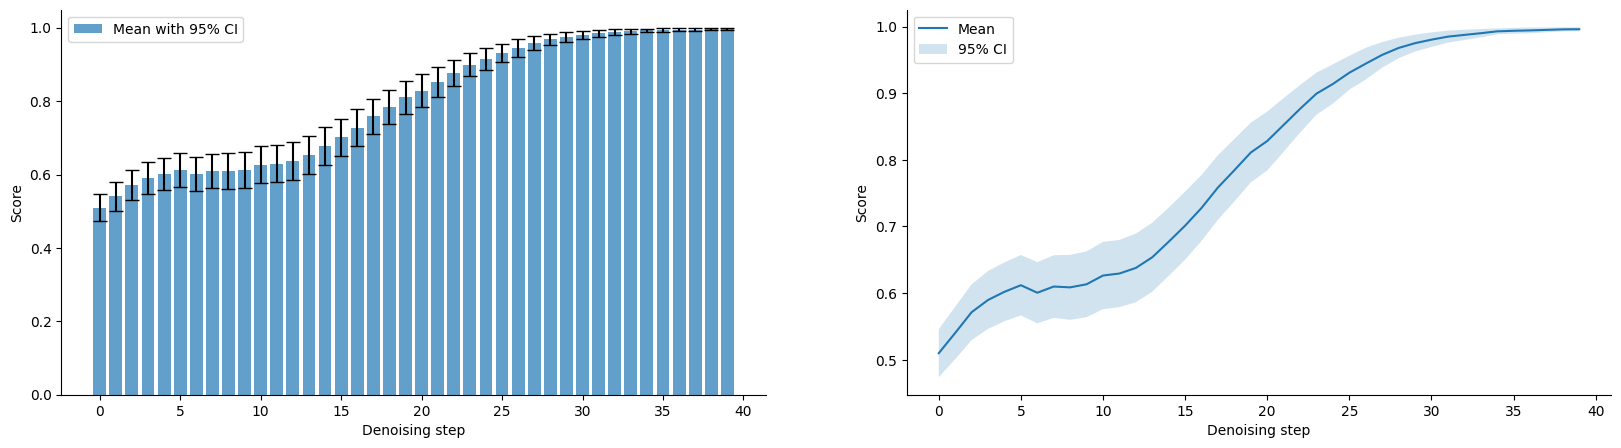

In [35]:
model = init_model(DEVICE)
model = load_model(model, all_models[-1])
step_scores = calc_step_scores(model)

mean = np.mean(step_scores, axis=0)
sem = np.std(step_scores, axis=0) / np.sqrt(step_scores.shape[0])  # SEM = std / sqrt(n)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Bar plot
ax1.bar(range(mean.shape[0]), mean, yerr=1.96*sem, capsize=5, alpha=0.7, label='Mean with 95% CI')
ax1.set_xlabel('Denoising step')
ax1.set_ylabel('Score')
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Line plot
ax2.plot(range(mean.shape[0]), mean, label='Mean')
ax2.fill_between(range(mean.shape[0]), mean - 1.96*sem, mean + 1.96*sem, alpha=0.2, label='95% CI')
ax2.set_xlabel('Denoising step')
ax2.set_ylabel('Score')
ax2.legend()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.savefig('../results/Imgs/group_level/score_rep.pdf')
plt.show()

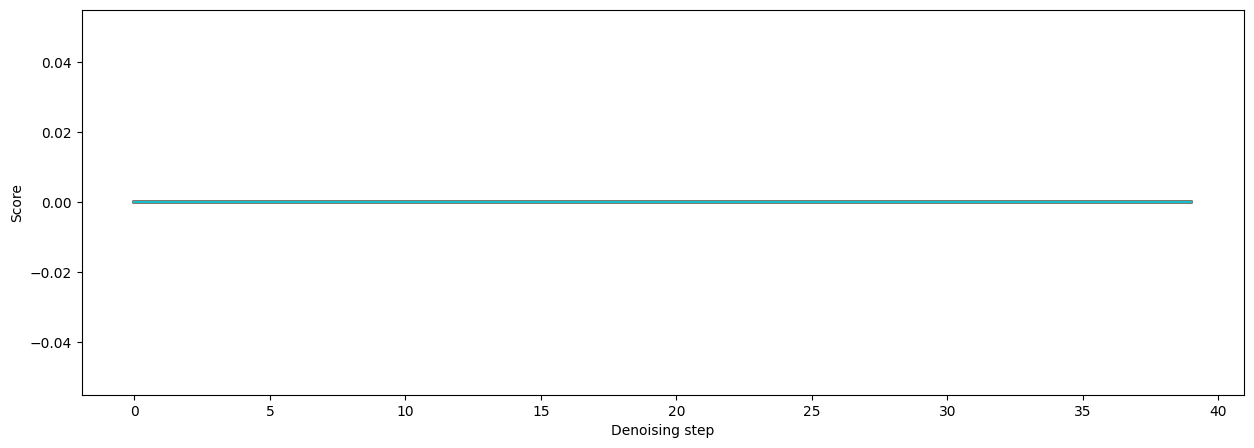

In [23]:
plt.figure(figsize=(15, 5))
for i in range(len(all_rewards)):
    rewards = all_rewards[i, :, :]
    plot_CI(rewards, str(i))
# plt.legend()
plt.show()

In [24]:
data = all_rewards_mean.copy()[:100]
cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=0, vmax=data.shape[0])  # Normalize based on the index range
fig, ax = plt.subplots(figsize=(12, 6))
for idx, row in enumerate(data):
    color = cmap(norm(idx))  # Get the color based on the index
    ax.scatter(range(40), data[idx, :], color=color)
    # ax.plot(row, color=color, alpha=.6)

# Add a colorbar for reference
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Episode')

ax.set_xlabel('Denoising step')  
ax.set_ylabel('Score')  

plt.title('Sub-'+model_name)

# for i in range(300):
#     plt.scatter(range(40), data[i, :], color=color)
plt.savefig(save_path + model_name+'_score_step_epoch_scatter_'+str(time())+'.pdf')
plt.show()

NameError: name 'all_rewards_mean' is not defined

In [27]:
all_rewards_mean = np.mean(all_rewards, axis=1)

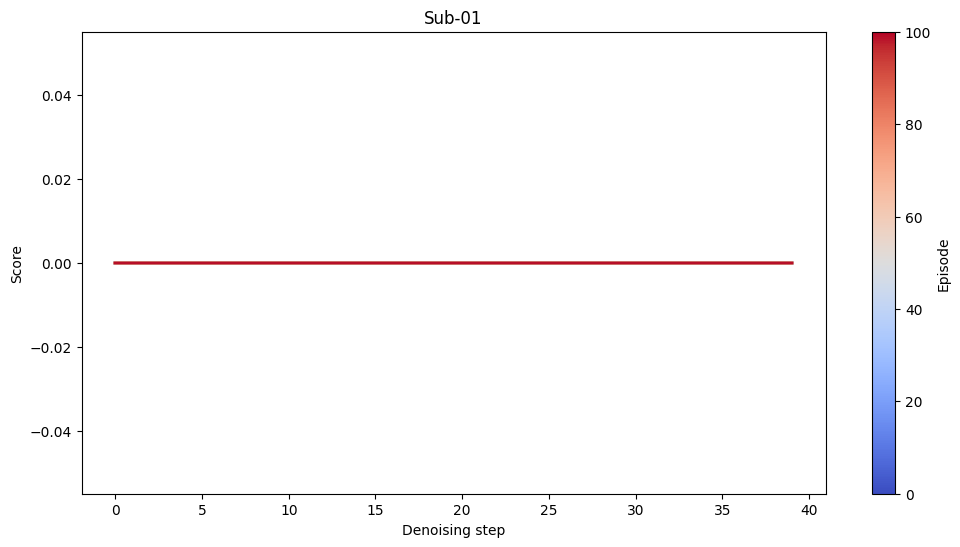

In [28]:
# Generate some example data
data = all_rewards_mean.copy()[:100]

# Prepare the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create a colormap from blue to red
cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=0, vmax=data.shape[0])  # Normalize based on the index range

# Plot each line
for idx, row in enumerate(data):
    color = cmap(norm(idx))  # Get the color based on the index
    ax.plot(row, color=color, alpha=.9)

# Add a colorbar for reference
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Episode')

ax.set_xlabel('Denoising step')  
ax.set_ylabel('Score')  
plt.title('Sub-'+model_name)

# plt.savefig(save_path + model_name+'_score_step_epoch_line'+str(time())+'.pdf')

plt.show()

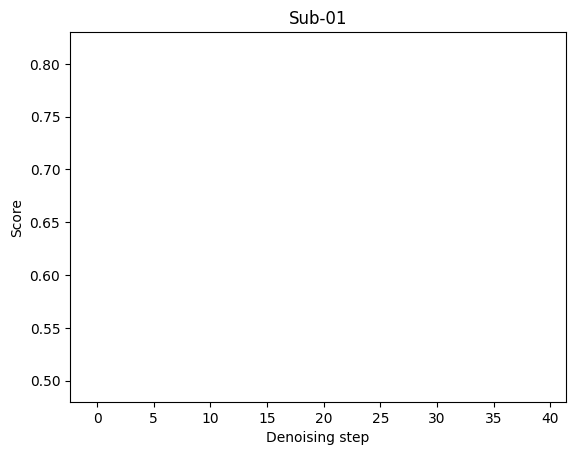

In [29]:
plt.bar(range(40), np.mean(all_rewards_mean[:100], axis=0))
plt.ylim(.48, .83)
plt.xlabel('Denoising step')
plt.ylabel('Score')
plt.title('Sub-'+model_name)

plt.savefig(save_path + "sub-"+model_name+'_score_step_mean_bar_'+str(time())+'.pdf')

plt.show()